In [1]:
#Librerías básicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Librerías para scrapear 
import requests
from bs4 import BeautifulSoup
from io import StringIO

#Librerías relacionadas con rutas
import os
import sys

#ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# TRATAMIENTO DE TABLAS

## Tabla de salarios

In [2]:
salaries_df = pd.read_csv("../data/raw/salaries.csv")
salaries_df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,Associate,113000,USD,113000,CA,0,CA,M
1,2024,SE,FT,Associate,75000,USD,75000,CA,0,CA,M
2,2024,SE,FT,Research Scientist,208000,USD,208000,US,0,US,M
3,2024,SE,FT,Research Scientist,147000,USD,147000,US,0,US,M
4,2024,SE,FT,Machine Learning Engineer,214500,USD,214500,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
59994,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
59995,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
59996,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
59997,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


Por lo que se nos indica en la fuente de la que se ha obtenido la información relativa a los salarios, los campos `salary_in_usd` y `salary` son análogos: uno viene expresado en dólares, mientras que el otro viene en la divisa que se indica en `salary_currency`. Nuestra variable a predecir es `salary_in_usd`, por lo que la otra podemos borrarla.

In [3]:
salaries_df.drop(columns=["salary"], inplace=True)

In [4]:
salaries_df.info() #No hay registros vacíos y hay campos tanto de tipo numérico como de tipo str

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59999 entries, 0 to 59998
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           59999 non-null  int64 
 1   experience_level    59999 non-null  object
 2   employment_type     59999 non-null  object
 3   job_title           59999 non-null  object
 4   salary_currency     59999 non-null  object
 5   salary_in_usd       59999 non-null  int64 
 6   employee_residence  59999 non-null  object
 7   remote_ratio        59999 non-null  int64 
 8   company_location    59999 non-null  object
 9   company_size        59999 non-null  object
dtypes: int64(3), object(7)
memory usage: 4.6+ MB


In [5]:
salaries_df.describe()

,work_year,salary_in_usd,remote_ratio
count,59999.000000,59999.000000,59999.000000
mean,2023.786763,159045.964883,22.177870
std,0.509777,72087.101137,41.408523
min,2020.000000,15000.000000,0.000000
25%,2024.000000,109100.000000,0.000000
50%,2024.000000,149000.000000,0.000000
75%,2024.000000,200000.000000,0.000000
max,2024.000000,800000.000000,100.000000


In [6]:
salaries_df.duplicated().value_counts() #Hay registros duplicados

True     31626
False    28373
Name: count, dtype: int64

In [7]:
#Borramos duplicados
salaries_df.drop_duplicates(inplace=True)
salaries_df.reset_index(inplace=True, drop=True)

In [8]:
salaries_df.describe()

,work_year,salary_in_usd,remote_ratio
count,28373.000000,28373.000000,28373.000000
mean,2023.728545,152403.360448,26.456490
std,0.594255,75684.533602,43.841405
min,2020.000000,15000.000000,0.000000
25%,2024.000000,98000.000000,0.000000
50%,2024.000000,141000.000000,0.000000
75%,2024.000000,192871.000000,100.000000
max,2024.000000,800000.000000,100.000000


### Análisis de la distribución del target

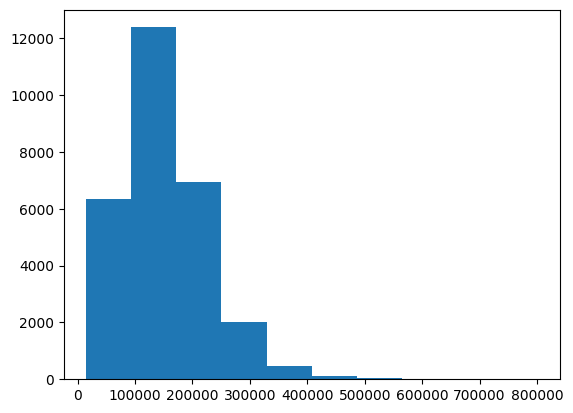

In [9]:
plt.hist(salaries_df["salary_in_usd"]);

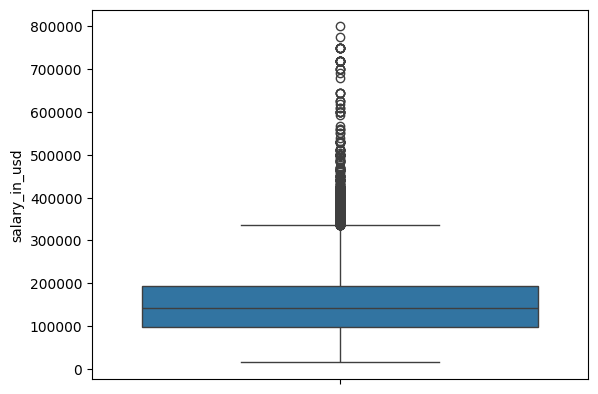

In [10]:
sns.boxplot(salaries_df["salary_in_usd"]);

La variable a predecir tiene una distribución asimétrica, además de tener numerosos outliers, lo cuales procedemos a detectar y borrar.

*(En un principio, se llevó a cabo una transformacion logaritmica del target, si bien ahora se va a probar borrando únicamente los outliers)*

In [ ]:
#salaries_df["salary_in_usd_log"] = np.log(salaries_df['salary_in_usd'])
#salaries_df.drop(columns=["salary_in_usd"], inplace=True)

In [ ]:
#La transformación logarítmica de los salarios presenta menos asimetría 
#salaries_df["salary_in_usd_log"].hist();

In [11]:
os.chdir('..') # Vamos a la carpeta previa
sys.path.append(os.getcwd())
from src.drop_outliers import drop_outliers

In [13]:
#Borramos los registros para los que el salario es un outlier
drop_outliers(salaries_df, "salary_in_usd")

In [14]:
#Guardamos la tabla adaotada de los salarios
salaries_df.to_csv("data/processed/unique_salaries_sin_outliers.csv", index=False)

## Tabla ISO

In [15]:
iso_df = pd.read_csv("data/raw/country_continent_ISO.csv")
iso_df

,Continent,Region,Country,Capital,FIPS,ISO (2),ISO (3),ISO (No),Internet,Note
0,Asia,South Asia,Afghanistan,Kabul,AF,AF,AFG,4.0,AF,NaN
1,Europe,South East Europe,Albania,Tirana,AL,AL,ALB,8.0,AL,NaN
2,Africa,Northern Africa,Algeria,Algiers,AG,DZ,DZA,12.0,DZ,NaN
3,Oceania,Pacific,American Samoa,Pago Pago,AQ,AS,ASM,16.0,AS,NaN
4,Europe,South West Europe,Andorra,Andorra la Vella,AN,AD,AND,20.0,AD,NaN
...,...,...,...,...,...,...,...,...,...,...
227,Oceania,Pacific,Western Samoa,Apia,WS,WS,WSM,882.0,WS,NaN
228,Asia,South West Asia,Yemen,Sanaa,YM,YE,YEM,887.0,YE,NaN
229,Africa,Central Africa,Zaire (Dem Rep of Congo),Kinshasa,CG,ZR,ZAR,180.0,ZR,8.0
230,Africa,Southern Africa,Zambia,Lusaka,ZA,ZM,ZWB,894.0,ZM,NaN


In [16]:
#Borramos las columnas que no necesitamos
iso_df.drop(columns=["FIPS", "ISO (No)", "Internet", "Note" ], inplace=True)

In [17]:
iso_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Continent  232 non-null    object
 1   Region     232 non-null    object
 2   Country    232 non-null    object
 3   Capital    231 non-null    object
 4   ISO (2)    231 non-null    object
 5   ISO (3)    232 non-null    object
dtypes: object(6)
memory usage: 11.0+ KB


## Join de tabla de salarios con tabla ISO

### Para el company_location

In [18]:
#Hacemos un left join de la tabla de salarios con la de los códigos ISO de los países
salaries_df = pd.merge(left=salaries_df, right=iso_df, how="left", left_on="company_location", right_on="ISO (2)")
salaries_df

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,Continent,Region,Country,Capital,ISO (2),ISO (3)
0,2024,SE,FT,Associate,USD,113000,CA,0,CA,M,Americas,North America,Canada,Ottawa,CA,CAN
1,2024,SE,FT,Associate,USD,75000,CA,0,CA,M,Americas,North America,Canada,Ottawa,CA,CAN
2,2024,SE,FT,Research Scientist,USD,208000,US,0,US,M,Americas,North America,United States,"Washington, DC",US,USA
3,2024,SE,FT,Research Scientist,USD,147000,US,0,US,M,Americas,North America,United States,"Washington, DC",US,USA
4,2024,SE,FT,Machine Learning Engineer,USD,214500,US,0,US,M,Americas,North America,United States,"Washington, DC",US,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27767,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,Americas,North America,United States,"Washington, DC",US,USA
27768,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,Americas,North America,United States,"Washington, DC",US,USA
27769,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,Americas,North America,United States,"Washington, DC",US,USA
27770,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,Americas,North America,United States,"Washington, DC",US,USA


In [19]:
#Renombramos columnas
salaries_df.rename(columns={"Continent":"company_continent", 
                    "Region":"company_region",
                    "Country":"company_country",
                    "Capital":"company_capital"}, inplace=True)

In [20]:
#Comprobamos si hay algún país de la tabla de salarios que no haya cruzado con la de los códigos ISO
salaries_df[salaries_df["company_continent"].isna()]

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,company_continent,company_region,company_country,company_capital,ISO (2),ISO (3)
18962,2024,SE,FT,Data Analyst,USD,54000,RS,100,RS,M,NaN,NaN,NaN,NaN,NaN,NaN
18963,2024,SE,FT,Data Analyst,USD,48000,RS,100,RS,M,NaN,NaN,NaN,NaN,NaN,NaN
25767,2023,MI,FT,Data Scientist,HKD,65058,HK,0,HK,L,NaN,NaN,NaN,NaN,NaN,NaN


Si nos fijamos en el output previo, vemos que hay tres registros para los que la tabla de salarios no ha cruzado con la de los códigos ISO:
- RS se corresponde con Serbia (Europa)
- HK se corresponde con Hong Kong (Asia)

Corregimos estos casos en la tabla original de los códigos ISO, para así arreglarlo en el origen.

SERBIA

In [21]:
iso_df[iso_df["Country"].str.contains("Serbia")]

,Continent,Region,Country,Capital,ISO (2),ISO (3)
183,Europe,South East Europe,Serbia and Montenegro,Belgrade / Podgorica,--,--


In [22]:
iso_df.loc[iso_df[iso_df["Country"].str.contains("Serbia")].index[0], "ISO (2)"] = "RS"

In [23]:
iso_df.loc[iso_df[iso_df["Country"].str.contains("Serbia")].index[0], "ISO (3)"] = "SRB"

HONG KONG

In [24]:
iso_df[iso_df["Country"].str.contains("Hong")]

,Continent,Region,Country,Capital,ISO (2),ISO (3)


In [25]:
iso_df[iso_df["Country"].str.upper().str.contains("HONG")]

,Continent,Region,Country,Capital,ISO (2),ISO (3)


In [26]:
#Hong Kong no estaba incluido en la tabla de los códigos ISO así que lo incluimos
hk = {"Continent":["Asia"], "Region": ["East Asia"], "Country": ["Hong Kong"], "Capital": ["-"], "ISO (2)": ["HK"], "ISO (3)":["HKG"]}
iso_df = pd.concat([iso_df, pd.DataFrame(hk)], axis=0, ignore_index = True)

In [27]:
#Guardamos la tabla corregida
iso_df.to_csv("data/processed/country_continent_ISO_fixed.csv", index=False)

In [28]:
salaries_df

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,company_continent,company_region,company_country,company_capital,ISO (2),ISO (3)
0,2024,SE,FT,Associate,USD,113000,CA,0,CA,M,Americas,North America,Canada,Ottawa,CA,CAN
1,2024,SE,FT,Associate,USD,75000,CA,0,CA,M,Americas,North America,Canada,Ottawa,CA,CAN
2,2024,SE,FT,Research Scientist,USD,208000,US,0,US,M,Americas,North America,United States,"Washington, DC",US,USA
3,2024,SE,FT,Research Scientist,USD,147000,US,0,US,M,Americas,North America,United States,"Washington, DC",US,USA
4,2024,SE,FT,Machine Learning Engineer,USD,214500,US,0,US,M,Americas,North America,United States,"Washington, DC",US,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27767,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,Americas,North America,United States,"Washington, DC",US,USA
27768,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,Americas,North America,United States,"Washington, DC",US,USA
27769,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,Americas,North America,United States,"Washington, DC",US,USA
27770,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,Americas,North America,United States,"Washington, DC",US,USA


In [29]:
#Borramos las columnas de los códigos ISO previamente incluidas en la de salarios mediante el join
salaries_df = salaries_df.iloc[:,:10]

In [30]:
#Hacemos de nuevo el join de las tablas
salaries_df = pd.merge(left=salaries_df, right=iso_df, how="left", left_on="company_location", right_on="ISO (2)")

In [31]:
#Renombramos de nuevo las columnas
salaries_df.rename(columns={"Continent":"company_continent", 
                    "Region":"company_region",
                    "Country":"company_country",
                    "Capital":"company_capital"}, inplace=True)

### Para el employee_residence

In [32]:
#Hacemos un left join de la tabla de salarios con la de los códigos ISO de los países, ahora para el campo de residencias de los empleados
salaries_df = pd.merge(left=salaries_df, right=iso_df, how="left", left_on="employee_residence", right_on="ISO (2)")
salaries_df

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,company_country,company_capital,ISO (2)_x,ISO (3)_x,Continent,Region,Country,Capital,ISO (2)_y,ISO (3)_y
0,2024,SE,FT,Associate,USD,113000,CA,0,CA,M,...,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN
1,2024,SE,FT,Associate,USD,75000,CA,0,CA,M,...,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN
2,2024,SE,FT,Research Scientist,USD,208000,US,0,US,M,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
3,2024,SE,FT,Research Scientist,USD,147000,US,0,US,M,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
4,2024,SE,FT,Machine Learning Engineer,USD,214500,US,0,US,M,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27767,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
27768,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
27769,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
27770,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA


In [33]:
#Renombramos columnas
salaries_df.rename(columns={"Continent":"employee_continent", 
                    "Region":"employee_region",
                    "Country":"employee_country",
                    "Capital":"employee_capital",
                    "ISO (2)_x":"company_iso2",
                    "ISO (3)_x":"company_iso3",
                    "ISO (2)_y":"employee_iso2",
                    "ISO (3)_y":"employee_iso3"}, inplace=True)

In [34]:
#Comprobamos si hay algún país de la tabla de salarios que, para los empleados, no haya cruzado con la de los códigos ISO
salaries_df[salaries_df["employee_continent"].isna()]

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,company_country,company_capital,company_iso2,company_iso3,employee_continent,employee_region,employee_country,employee_capital,employee_iso2,employee_iso3
27652,2021,EN,FT,Research Scientist,USD,100000,JE,0,CN,L,...,China,Beijing,CN,CHN,NaN,NaN,NaN,NaN,NaN,NaN


Si nos fijamos en el output previo, vemos que hay un registro para el que la tabla de salarios no ha cruzado con la de los códigos ISO:

- JE se corresponde con Jersey (Europa)

Corregimos este caso en la tabla original de los códigos ISO, para así arreglarlo en el origen.

In [35]:
iso_df[iso_df["Country"].str.upper().str.contains("JERSEY")]

,Continent,Region,Country,Capital,ISO (2),ISO (3)
103,Europe,Western Europe,Jersey,Saint Helier,--,--


In [36]:
iso_df.loc[iso_df[iso_df["Country"].str.upper().str.contains("JERSEY")].index[0], "ISO (2)"] = "JE"
iso_df.loc[iso_df[iso_df["Country"].str.upper().str.contains("JERSEY")].index[0], "ISO (3)"] = "JEY"

In [37]:
#Guardamos la tabla corregida
iso_df.to_csv("data/processed/country_continent_ISO_fixed.csv", index=False)

In [38]:
salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27772 entries, 0 to 27771
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           27772 non-null  int64 
 1   experience_level    27772 non-null  object
 2   employment_type     27772 non-null  object
 3   job_title           27772 non-null  object
 4   salary_currency     27772 non-null  object
 5   salary_in_usd       27772 non-null  int64 
 6   employee_residence  27772 non-null  object
 7   remote_ratio        27772 non-null  int64 
 8   company_location    27772 non-null  object
 9   company_size        27772 non-null  object
 10  company_continent   27772 non-null  object
 11  company_region      27772 non-null  object
 12  company_country     27772 non-null  object
 13  company_capital     27772 non-null  object
 14  company_iso2        27772 non-null  object
 15  company_iso3        27772 non-null  object
 16  employee_continent  27

In [39]:
#Borramos las columnas de los códigos ISO previamente incluidas en la de salarios mediante el join
salaries_df = salaries_df.iloc[:,:16]

In [40]:
#Hacemos el left join de nuevo
salaries_df = pd.merge(left=salaries_df, right=iso_df, how="left", left_on="employee_residence", right_on="ISO (2)")

#Renombramos de nuevo las columnas
salaries_df.rename(columns={"Continent":"employee_continent", 
                    "Region":"employee_region",
                    "Country":"employee_country",
                    "Capital":"employee_capital",
                    "ISO (2)":"employee_iso2",
                    "ISO (3)":"employee_iso3"}, inplace=True)

## Tabla de PIB

In [41]:
pib_df = pd.read_csv("data/raw/API_NY.GDP.MKTP.KD_DS2_es_csv_v2_2115/API_NY.GDP.MKTP.KD_DS2_es_csv_v2_2115.csv", header=2)
pib_df.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
0,Aruba,ABW,PIB (US$ a precios constantes de 2015),NY.GDP.MKTP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.962907e+09,3.013858e+09,3.226291e+09,3.303132e+09,3.227067e+09,2.453133e+09,3.131163e+09,3.458630e+09,NaN,NaN
1,NaN,AFE,PIB (US$ a precios constantes de 2015),NY.GDP.MKTP.KD,1.528011e+11,1.535042e+11,1.655819e+11,1.748817e+11,1.830454e+11,1.924521e+11,...,8.992957e+11,9.189325e+11,9.432971e+11,9.685937e+11,9.897987e+11,9.622785e+11,1.005556e+12,1.041298e+12,1.068604e+12,NaN


In [42]:
pib_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            141 non-null    float64
 5   1961            149 non-null    float64
 6   1962            149 non-null    float64
 7   1963            149 non-null    float64
 8   1964            149 non-null    float64
 9   1965            153 non-null    float64
 10  1966            157 non-null    float64
 11  1967            159 non-null    float64
 12  1968            159 non-null    float64
 13  1969            159 non-null    float64
 14  1970            182 non-null    float64
 15  1971            182 non-null    float64
 16  1972            182 non-null    float64
 17  1973            182 non-null    flo

- Esta tabla contiene el PIB de cada país desde 1960 hasta 2023 en dólares, a precio constante desde 2015. No obstante, para algunos países no está la información correspondiente a cada uno de esos años. Por ello, vamos a calcular la media del PIB de cada uno de de los países, siendo este el valor que usaremos para cada país. (Es decir, puesto que cada registro representa un país, vamos a calcular la media a nivel registro, para así tener el PIB medio de cada sitio)

- La última columna está completamente vacía, por lo que también la eliminaremos.

- Para evitar fallos, a los dos registros que tienen el nombre del país sin informar los vamos a indicar como desconocidos

In [43]:
#Indicamos como desconocidos los países con nombre vacío
pib_df["Country Name"].fillna("Unknown", inplace=True)

C:\Users\tamar\AppData\Local\Temp\ipykernel_26388\3910946890.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pib_df["Country Name"].fillna("Unknown", inplace=True)


In [44]:
#Eliminamos la columna de nulos
pib_df.drop(columns=["Unnamed: 68"], inplace=True)

In [45]:
#Definición de una columna nueva con la media de los PIBs
mean_pib =[]
for i in range(len(pib_df)):
    mean_pib.append(pib_df.iloc[i, 4:].mean())
mean_pib

[2596102515.182239,
 488925744841.86316,
 14180778311.558445,
 369343120022.4958,
 49406326429.60504,
 7907615249.208133,
 2071126646.6813192,
 1390095083183.8687,
 201701604995.3439,
 359259016486.8221,
 7720264584.694791,
 684204434.7509997,
 1098519943.987956,
 754979901077.8411,
 254513743758.84842,
 32343960647.55812,
 2021470070.9625669,
 307562248674.5804,
 5913931042.446471,
 5426671266.879408,
 91382859476.2858,
 41807474718.66812,
 16552140003.193941,
 8012584232.085949,
 12524533667.608826,
 41572776710.00868,
 1052544698.6857731,
 5156205890.2028055,
 17030555149.407413,
 1023314980970.2665,
 3696240101.7403207,
 11088267816.617077,
 934175767.9805629,
 6490094636.56399,
 1559480493.5385435,
 961131567709.3438,
 1062450479229.0648,
 479952365875.401,
 nan,
 115482044676.85919,
 3837071247897.453,
 27124579989.88643,
 17462371643.088657,
 27516306725.936344,
 5931814638.740941,
 148242244548.23453,
 716135069.4731555,
 1039906346.1533939,
 27668048489.16656,
 23025498603.872

In [46]:
pib_df["mean_pib"] = mean_pib

In [47]:
pib_df.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,mean_pib
0,Aruba,ABW,PIB (US$ a precios constantes de 2015),NY.GDP.MKTP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.962907e+09,3.013858e+09,3.226291e+09,3.303132e+09,3.227067e+09,2.453133e+09,3.131163e+09,3.458630e+09,NaN,2.596103e+09
1,Unknown,AFE,PIB (US$ a precios constantes de 2015),NY.GDP.MKTP.KD,1.528011e+11,1.535042e+11,1.655819e+11,1.748817e+11,1.830454e+11,1.924521e+11,...,8.992957e+11,9.189325e+11,9.432971e+11,9.685937e+11,9.897987e+11,9.622785e+11,1.005556e+12,1.041298e+12,1.068604e+12,4.889257e+11


In [48]:
#Borramos todas las columnas de la tabla previa a excepción de: nombre del país, código del país y media del PIB
pib_df = pib_df.iloc[:,[0,1,-1]]
pib_df.head(2)

,Country Name,Country Code,mean_pib
0,Aruba,ABW,2.596103e+09
1,Unknown,AFE,4.889257e+11


In [49]:
#Guardamos la tabla adaptada
pib_df.to_csv("data/processed/mean_pib_per_country.csv", index=False)

## Join de tabla de salarios con tabla PIB

Vamos a hacer el join de la tabla de salarios con la del PIB para la columna correspondiente a la localización de la compañía

In [50]:
#Hacemos un left join de la tabla de salarios con la de las medias del pib
salaries_df = pd.merge(left=salaries_df, right=pib_df, how="left", left_on= 'company_iso3', right_on= "Country Code")
salaries_df

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,company_iso3,employee_continent,employee_region,employee_country,employee_capital,employee_iso2,employee_iso3,Country Name,Country Code,mean_pib
0,2024,SE,FT,Associate,USD,113000,CA,0,CA,M,...,CAN,Americas,North America,Canada,Ottawa,CA,CAN,Canadá,CAN,9.611316e+11
1,2024,SE,FT,Associate,USD,75000,CA,0,CA,M,...,CAN,Americas,North America,Canada,Ottawa,CA,CAN,Canadá,CAN,9.611316e+11
2,2024,SE,FT,Research Scientist,USD,208000,US,0,US,M,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
3,2024,SE,FT,Research Scientist,USD,147000,US,0,US,M,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
4,2024,SE,FT,Machine Learning Engineer,USD,214500,US,0,US,M,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27767,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
27768,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
27769,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
27770,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13


In [51]:
#Vamos a ver si tenemos algún país para el que no se haya realizado correctamente el join y su pib aparezca vacío
salaries_df[salaries_df["mean_pib"].isna()][["company_country", "company_iso3"]]

,company_country,company_iso3
15736,Romania,ROM
15801,Romania,ROM
15806,Venezuela,VEN
15807,Venezuela,VEN
21768,Romania,ROM
23533,Gibraltar,GIB
23657,Romania,ROM
26342,Romania,ROM
27541,Romania,ROM


Si nos fijamos en el output previo, vemos que hay varios países que no han cruzado: Rumanía, Venezuela y Gibraltar. Vamos a corregir esto en la tabla del PIB, para así tenerlo unificado con los códigos de la tabla de ISO que estamos trabajando.

RUMANÍA

In [52]:
pib_df[pib_df["Country Name"].str.upper().str.contains("RUMAN")]

,Country Name,Country Code,mean_pib
201,Rumania,ROU,1.488480e+11


In [53]:
pib_df.loc[pib_df[pib_df["Country Name"].str.upper().str.contains("RUMAN")].index[0], "Country Code"] = "ROM"

VENEZUELA

In [54]:
pib_df[pib_df["Country Name"].str.upper().str.contains("VENEZ")]

,Country Name,Country Code,mean_pib
254,Venezuela,VEN,NaN


No disponemos del PIB de Venezuela, por lo que vamos a asignarle el valor de **92210 millones de USD**, el cual hemos obtenido de [aquí](https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_por_PIB_(nominal))

In [55]:
pib_df.loc[pib_df[pib_df["Country Name"].str.upper().str.contains("VENEZ")].index[0],"mean_pib"] = 92210000000

GIBRALTAR

In [56]:
pib_df[pib_df["Country Name"].str.upper().str.contains("GIBRAL")]

,Country Name,Country Code,mean_pib
84,Gibraltar,GIB,NaN


Tampoco disponemos del PIB de Gibraltar, por lo que vamos a asignarle el valor de **2044 millones de USD**, el cual hemos obtenido de [aquí](https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_por_PIB_(nominal))

In [57]:
pib_df.loc[pib_df[pib_df["Country Name"].str.upper().str.contains("GIBRAL")].index[0],"mean_pib"] = 2044000000

In [58]:
#Actualizamos la tabla del PIB
pib_df.to_csv("data/processed/mean_pib_per_country.csv", index=False)

In [59]:
salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27772 entries, 0 to 27771
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           27772 non-null  int64  
 1   experience_level    27772 non-null  object 
 2   employment_type     27772 non-null  object 
 3   job_title           27772 non-null  object 
 4   salary_currency     27772 non-null  object 
 5   salary_in_usd       27772 non-null  int64  
 6   employee_residence  27772 non-null  object 
 7   remote_ratio        27772 non-null  int64  
 8   company_location    27772 non-null  object 
 9   company_size        27772 non-null  object 
 10  company_continent   27772 non-null  object 
 11  company_region      27772 non-null  object 
 12  company_country     27772 non-null  object 
 13  company_capital     27772 non-null  object 
 14  company_iso2        27772 non-null  object 
 15  company_iso3        27772 non-null  object 
 16  empl

In [60]:
#Borramos las columnas los PIB medios de cada país, para volver a hacer el join con la tabla del PIB arreglada
salaries_df = salaries_df.iloc[:,:22]

In [61]:
#Hacemos de nuevo el left join de la tabla de salarios con la de las medias del pib
salaries_df = pd.merge(left=salaries_df, right=pib_df, how="left", left_on= 'company_iso3', right_on= "Country Code")

## Tasa de desempleo

In [62]:
unemployment_df = pd.read_csv("data/raw/unemployment-rate-imf/unemployment-rate-imf.csv")
unemployment_df

,Entity,Code,Year,Unemployment rate - Percent of total labor force - Observations,Unemployment rate - Percent of total labor force - Forecasts
0,Albania,ALB,1980,5.028,NaN
1,Albania,ALB,1981,4.224,NaN
2,Albania,ALB,1982,2.813,NaN
3,Albania,ALB,1983,3.335,NaN
4,Albania,ALB,1984,4.410,NaN
...,...,...,...,...,...
4626,Vietnam,VNM,2025,NaN,2.030
4627,Vietnam,VNM,2026,NaN,1.998
4628,Vietnam,VNM,2027,NaN,1.965
4629,Vietnam,VNM,2028,NaN,1.933


En este dataset hay información sobre el ratio (observado) de desempleo desde el año 1980 hasta el 2023, además de las previsiones a corto plazo. Para nuestro caso, nosotros vamos a quedarnos sólo, de entre las observadas y no las previstas, con las más recientes. Para más información y contexto acerca de estos datos, leer [esto](../data/raw/unemployment-rate-imf/readme.md).

In [63]:
#Toda la información que hay a partir del año 2024 se tratan de previsiones
unemployment_df[unemployment_df["Year"].isin([2024, 2025, 2026, 2027, 2028, 2029])]["Unemployment rate - Percent of total labor force - Observations"].value_counts()

Series([], Name: count, dtype: int64)

In [64]:
#Por lo comentado previamente, borramos los datos desde el año 2024 en adelante y, adicionalmente,
#todos aquellos años que sean menores a 2020, puesto que nuestro dataset de salarios va del 2020 al 2024
unemployment_df = unemployment_df[(unemployment_df["Year"] == 2020)|(unemployment_df["Year"] == 2021)|(unemployment_df["Year"] == 2022)|(unemployment_df["Year"] == 2023)]
unemployment_df.reset_index(drop=True, inplace=True) #Reseteamos los índices

In [66]:
#Eliminamos la columna de las previsiones
unemployment_df = unemployment_df.iloc[:, :-1]

In [67]:
unemployment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 4 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Entity                                                           427 non-null    object 
 1   Code                                                             423 non-null    object 
 2   Year                                                             427 non-null    int64  
 3   Unemployment rate - Percent of total labor force - Observations  351 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 13.5+ KB


Hay registros para los que se desconoce la tasa de desempleo. Así pues, vamos a calcular la media de la tasa para cada país:

In [68]:
unemployment_dict = {}
for country in unemployment_df["Code"]:
    unemployment_dict[country] = unemployment_df[unemployment_df["Code"] == country]["Unemployment rate - Percent of total labor force - Observations"].mean()
unemployment_mean = pd.DataFrame.from_dict(unemployment_dict, orient='index', columns=['Value'])
unemployment_mean.reset_index(inplace=True)
unemployment_mean

,index,Value
0,ALB,11.391667
1,AND,2.456250
2,ARG,9.041667
3,ARM,16.850000
4,ABW,8.700000
...,...,...
103,GBR,4.293750
104,USA,5.175000
105,URY,9.197333
106,UZB,9.339500


## Join de tabla de salarios con tabla de tasa de desempleo

Vamos a hacer el join de la tabla de salarios con la de la tasa de desempleo para la columna correspondiente a la localización de la compañía.

In [72]:
salaries_df = pd.merge(left=salaries_df, right=unemployment_mean, how="left", left_on="company_iso3", right_on="index")

In [76]:
salaries_df.rename(columns={"Value": "unemployment_rate"}, inplace=True)

In [78]:
#Vamos a ver si tenemos algún país para el que no esté informada la tasa de desempleo
salaries_df[salaries_df["unemployment_rate"].isna()]

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,employee_region,employee_country,employee_capital,employee_iso2,employee_iso3,Country Name,Country Code,mean_pib,index,unemployment_rate
769,2024,SE,FT,Data Lead,USD,210000,LB,0,LB,M,...,South West Asia,Lebanon,Beirut,LB,LBN,Líbano,LBN,3.232416e+10,NaN,NaN
770,2024,SE,FT,Data Lead,USD,122500,LB,0,LB,M,...,South West Asia,Lebanon,Beirut,LB,LBN,Líbano,LBN,3.232416e+10,NaN,NaN
4264,2024,SE,FT,Data Manager,USD,73700,KE,0,KE,M,...,Eastern Africa,Kenya,Nairobi,KE,KEN,Kenya,KEN,3.567740e+10,NaN,NaN
4265,2024,SE,FT,Data Manager,USD,55300,KE,0,KE,M,...,Eastern Africa,Kenya,Nairobi,KE,KEN,Kenya,KEN,3.567740e+10,NaN,NaN
5860,2024,MI,FT,Associate,INR,24075,IN,0,IN,M,...,South Asia,India,New Delhi,IN,IND,India,IND,8.776548e+11,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27696,2021,MI,FT,Big Data Engineer,INR,22611,IN,0,IN,L,...,South Asia,India,New Delhi,IN,IND,India,IND,8.776548e+11,NaN,NaN
27705,2021,MI,FT,Data Scientist,INR,33808,IN,0,IN,M,...,South Asia,India,New Delhi,IN,IND,India,IND,8.776548e+11,NaN,NaN
27749,2021,EN,FT,AI Scientist,INR,18053,IN,100,AS,S,...,South Asia,India,New Delhi,IN,IND,Samoa Americana,ASM,6.842044e+08,NaN,NaN
27754,2021,MI,FT,Lead Data Analyst,INR,19609,IN,100,IN,L,...,South Asia,India,New Delhi,IN,IND,India,IND,8.776548e+11,NaN,NaN


In [80]:
salaries_df[salaries_df["unemployment_rate"].isna()]["company_iso3"].value_counts()

company_iso3
IND    92
NGA     9
LBN     8
KEN     6
ROM     6
ARE     5
ASM     4
KOR     4
GHA     3
DZA     2
VEN     2
CAF     2
OMN     1
GIB     1
QAT     1
BHS     1
IRQ     1
Name: count, dtype: int64

Fijándonos en lo anterior, vemos que esto no pasa para muchos registros, así que los borramos.

In [81]:
#Borramos los registros de países para los que no conocemos la tasa de desempleo
salaries_df.dropna(subset="unemployment_rate", inplace=True) 
salaries_df.reset_index(drop=True, inplace=True)

In [82]:
salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27624 entries, 0 to 27623
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           27624 non-null  int64  
 1   experience_level    27624 non-null  object 
 2   employment_type     27624 non-null  object 
 3   job_title           27624 non-null  object 
 4   salary_currency     27624 non-null  object 
 5   salary_in_usd       27624 non-null  int64  
 6   employee_residence  27624 non-null  object 
 7   remote_ratio        27624 non-null  int64  
 8   company_location    27624 non-null  object 
 9   company_size        27624 non-null  object 
 10  company_continent   27624 non-null  object 
 11  company_region      27624 non-null  object 
 12  company_country     27624 non-null  object 
 13  company_capital     27624 non-null  object 
 14  company_iso2        27624 non-null  object 
 15  company_iso3        27624 non-null  object 
 16  empl

# BORRAMOS COLUMNAS INNECESARIAS

Por los diversos joins que hemos ido haciendo, tenemos columnas duplicadas. Así pues, vamos a echar un vistazo rápido a todas ellas para ver cuáles podemos eliminar.

In [83]:
pd.options.display.max_columns = None
salaries_df.head(5)

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,company_continent,company_region,company_country,company_capital,company_iso2,company_iso3,employee_continent,employee_region,employee_country,employee_capital,employee_iso2,employee_iso3,Country Name,Country Code,mean_pib,index,unemployment_rate
0,2024,SE,FT,Associate,USD,113000,CA,0,CA,M,Americas,North America,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN,Canadá,CAN,9.611316e+11,CAN,6.97075
1,2024,SE,FT,Associate,USD,75000,CA,0,CA,M,Americas,North America,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN,Canadá,CAN,9.611316e+11,CAN,6.97075
2,2024,SE,FT,Research Scientist,USD,208000,US,0,US,M,Americas,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13,USA,5.17500
3,2024,SE,FT,Research Scientist,USD,147000,US,0,US,M,Americas,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13,USA,5.17500
4,2024,SE,FT,Machine Learning Engineer,USD,214500,US,0,US,M,Americas,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13,USA,5.17500


In [84]:
#Borramos columnas innecesarias por estar duplicadas
salaries_df.drop(columns=["employee_residence", "company_location", "Country Name", "Country Code", "index"], inplace=True)

# MAPA DE CALOR (I)

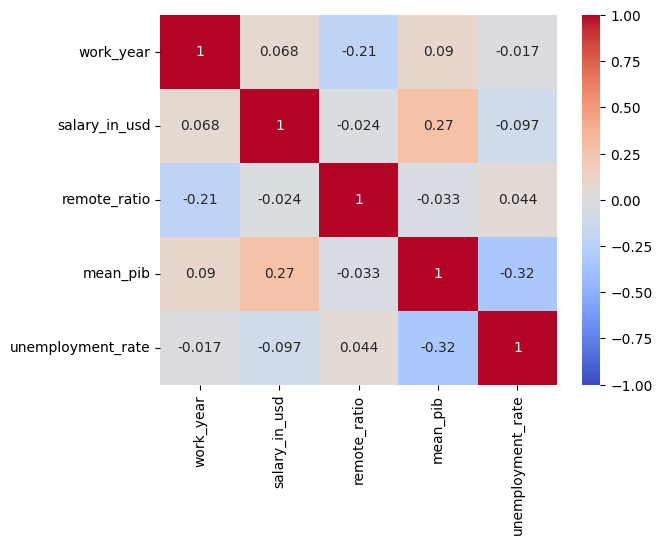

In [85]:
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="coolwarm");

# TRATAMIENTO DE VARIABLES CATEGÓRICAS (I)

## 1. experience_level

In [87]:
salaries_df["experience_level"].replace({"EN":1,
                               "MI":2,
                               "SE":3,
                               "EX":4

}, inplace=True)

C:\Users\tamar\AppData\Local\Temp\ipykernel_26388\3695592884.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  salaries_df["experience_level"].replace({"EN":1,
C:\Users\tamar\AppData\Local\Temp\ipykernel_26388\3695592884.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  salaries_df["experience_l

### Mapa de calor (II)

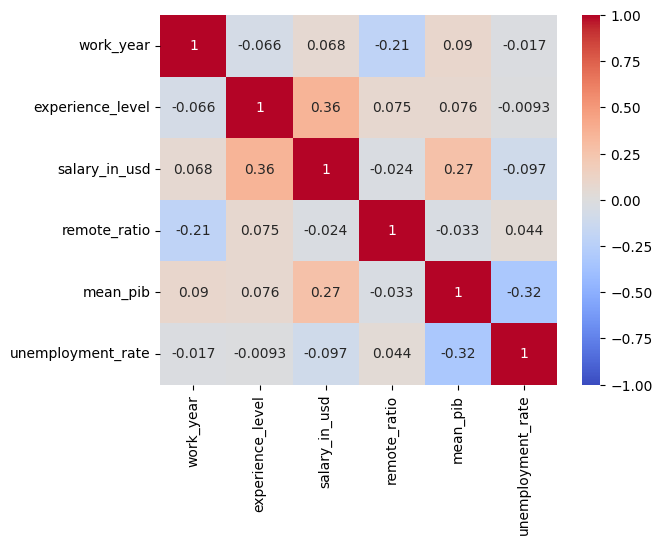

In [88]:
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="coolwarm");

## 2. company_size

In [89]:
salaries_df["company_size"].value_counts()

company_size
M    26536
L      909
S      179
Name: count, dtype: int64

In [90]:
salaries_df["company_size"].replace({"S":1,
                               "M":2,
                               "L":3

}, inplace=True)

C:\Users\tamar\AppData\Local\Temp\ipykernel_26388\985676451.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  salaries_df["company_size"].replace({"S":1,
C:\Users\tamar\AppData\Local\Temp\ipykernel_26388\985676451.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  salaries_df["company_size"].repl

### Mapa de calor (III)

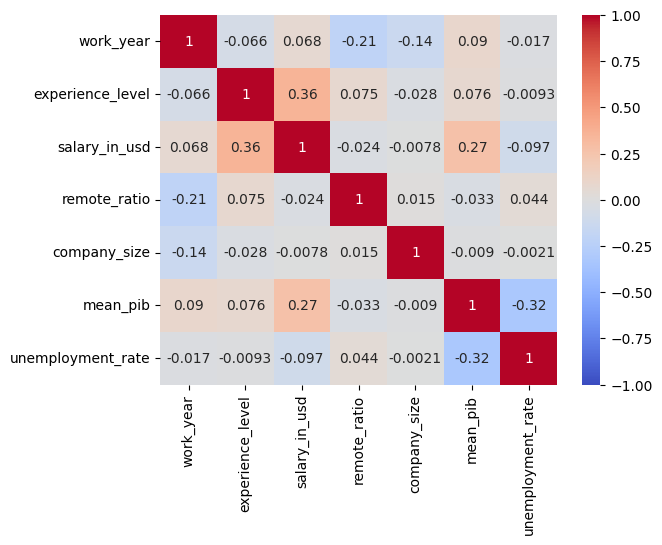

In [91]:
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="coolwarm");

## 3. employment_type

In [92]:
salaries_df["employment_type"].value_counts()

employment_type
FT    27419
PT      101
CT       94
FL       10
Name: count, dtype: int64

In [93]:
#Aplicamos un get dummies para poder ver la correlación de cada uno de los tipos de empleo con el salario
emp_type_dummies = pd.get_dummies(salaries_df["employment_type"], dtype=int)
emp_type_dummies.rename(columns={"CT": "contract",
                         "FL":"freelance",
                         "FT":"full_time",
                         "PT":"part_time"
                         }, inplace=True)
salaries_df = pd.concat([salaries_df, emp_type_dummies], axis=1)

In [94]:
salaries_df.drop(columns=["employment_type"], inplace=True) #Borramos la columna del tipo de empleo, pues esta información está en las dummies previamente creadas

### Mapa de calor (IV)

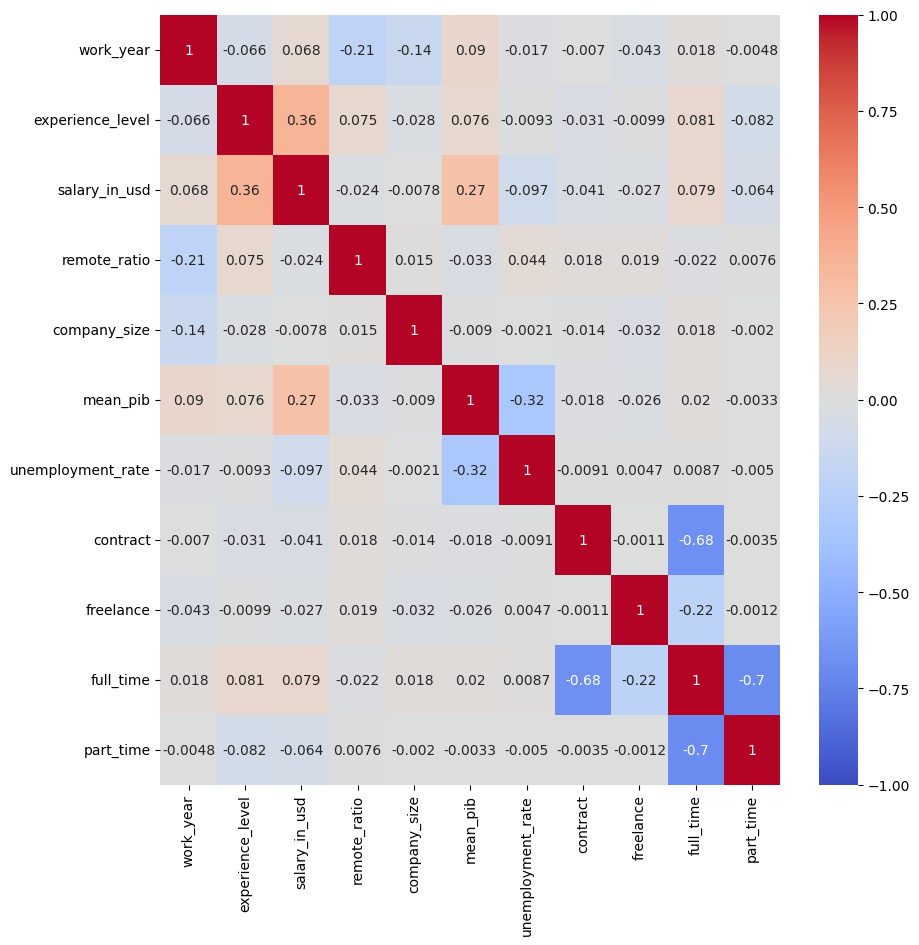

In [95]:
plt.figure(figsize=(10,10))
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="coolwarm");

## 4. Localización de la compañía y residencia del empleado

In [96]:
salaries_df["company_country"].value_counts(normalize=True) #La mayoria de las empresas están en US, seguido de CA y GB

company_country
United States     0.850927
Canada            0.053215
United Kingdom    0.042463
Germany           0.006299
Australia         0.005539
                    ...   
Hong Kong         0.000036
Iran              0.000036
Malaysia          0.000036
China             0.000036
Moldova           0.000036
Name: proportion, Length: 65, dtype: float64

In [97]:
salaries_df["employee_country"].value_counts(normalize=True) #La mayoria de los empleados están en US, seguido de CA y GB

employee_country
United States     0.849044
Canada            0.053142
United Kingdom    0.042173
Germany           0.006009
Australia         0.005394
                    ...   
Kuwait            0.000036
Uganda            0.000036
Ghana             0.000036
Andorra           0.000036
Mauritius         0.000036
Name: proportion, Length: 79, dtype: float64

In [98]:
print("Hay un total de", len(salaries_df[salaries_df["company_country"] == salaries_df["employee_country"]]), "puestos para los que coincide la residencia del trabajador y la localización de la sede de la empresa")
print("\n")
print("Hay un total de", len(salaries_df[salaries_df["company_country"] != salaries_df["employee_country"]]), "puestos para los que NO coincide la residencia del trabajador y la localización de la sede de la empresa")

Hay un total de 27495 puestos para los que coincide la residencia del trabajador y la localización de la sede de la empresa


Hay un total de 129 puestos para los que NO coincide la residencia del trabajador y la localización de la sede de la empresa


In [99]:
salaries_df[salaries_df["company_country"] == salaries_df["employee_country"]]["company_country"].value_counts(normalize=True) 
#De todos los puestos para los que residencia del empleado y localización de la empresa coinciden, la mayoría aplican a USA, sefuido de CA y GB

company_country
United States     0.852773
Canada            0.053246
United Kingdom    0.042335
Germany           0.005856
Australia         0.005346
                    ...   
Ecuador           0.000036
Hong Kong         0.000036
Iran              0.000036
Indonesia         0.000036
Moldova           0.000036
Name: proportion, Length: 63, dtype: float64

Por todo lo visto en el análisis previo, la gran mayoría de los puestos se corresponden a personas que viven en Estados Unidos y trabajan en una empresa localizada en dicho país. Vamos a crear entonces una variable que indique si para el puesto se cumple esto o no, para distinguir la mayoría de los casos del resto

In [104]:
salaries_df["company_employee_US"] = np.where((salaries_df["company_country"] == "United States")&(salaries_df["employee_country"] == "United States"), 1, 0)
salaries_df

,work_year,experience_level,job_title,salary_currency,salary_in_usd,remote_ratio,company_size,company_region,company_country,company_capital,company_iso2,company_iso3,employee_continent,employee_region,employee_country,employee_capital,employee_iso2,employee_iso3,mean_pib,unemployment_rate,contract,freelance,full_time,part_time,company_employee_US,company__Africa,company__Americas,company__Asia,company__Europe,company__Oceania
0,2024,3,Associate,USD,113000,0,2,North America,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN,9.611316e+11,6.97075,0,0,1,0,0,0,1,0,0,0
1,2024,3,Associate,USD,75000,0,2,North America,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN,9.611316e+11,6.97075,0,0,1,0,0,0,1,0,0,0
2,2024,3,Research Scientist,USD,208000,0,2,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,1.111938e+13,5.17500,0,0,1,0,1,0,1,0,0,0
3,2024,3,Research Scientist,USD,147000,0,2,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,1.111938e+13,5.17500,0,0,1,0,1,0,1,0,0,0
4,2024,3,Machine Learning Engineer,USD,214500,0,2,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,1.111938e+13,5.17500,0,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27619,2021,2,Data Engineer,EUR,28369,50,3,Southern Europe,Malta,Valletta,MT,MLT,Europe,Southern Europe,Malta,Valletta,MT,MLT,6.141543e+09,3.29575,0,0,1,0,0,0,0,0,1,0
27620,2021,3,Data Specialist,USD,165000,100,3,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,1.111938e+13,5.17500,0,0,1,0,1,0,1,0,0,0
27621,2021,2,Principal Data Scientist,USD,151000,100,3,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,1.111938e+13,5.17500,0,0,1,0,1,0,1,0,0,0
27622,2020,1,Data Scientist,USD,105000,100,1,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,1.111938e+13,5.17500,0,0,1,0,1,0,1,0,0,0


### company_continent

In [101]:
salaries_df["company_continent"].value_counts()

company_continent
Americas    25132
Europe       2144
Oceania       173
Asia          104
Africa         71
Name: count, dtype: int64

In [102]:
#Aplicamos un get dummies para poder ver la correlación del continente en el que está la compañia y el salario
comp_cont_dummies = pd.get_dummies(salaries_df["company_continent"], dtype=int, prefix="company_")
salaries_df = pd.concat([salaries_df, comp_cont_dummies], axis=1)

#Borramos la columna original de la que hemos sacado las dummies previamente creadas
salaries_df.drop(columns=["company_continent"], inplace=True)

### Mapa de calor (V)

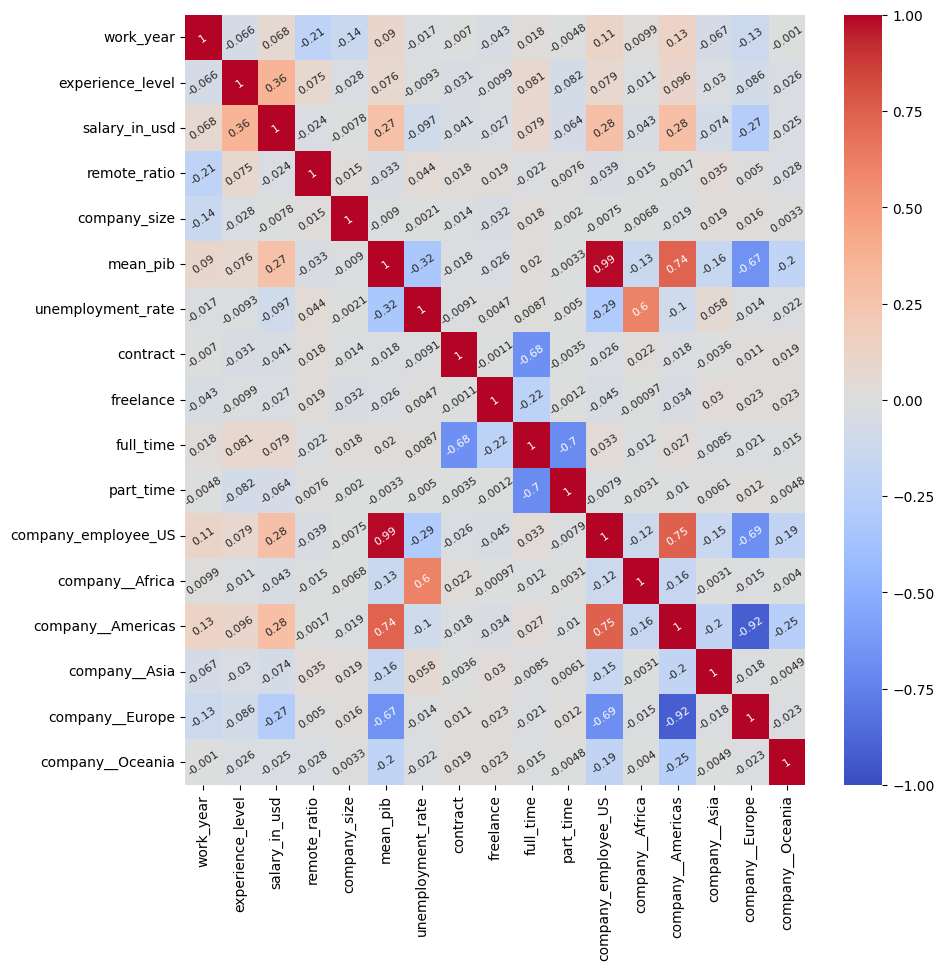

In [106]:
plt.figure(figsize=(10,10))
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, annot_kws={'size': 8, 'rotation': 35}, cmap="coolwarm");

## 5. job_title

In [107]:
pd.set_option("display.max_rows", None)
salaries_df["job_title"].value_counts().sort_values(ascending=False)

job_title
Data Scientist                               3805
Data Engineer                                3538
Data Analyst                                 2944
Machine Learning Engineer                    1881
Software Engineer                            1701
Engineer                                     1279
Manager                                       926
Research Scientist                            737
Analytics Engineer                            628
Data Architect                                579
Analyst                                       532
Research Engineer                             454
Product Manager                               401
Associate                                     393
Business Intelligence Analyst                 334
AI Engineer                                   320
Applied Scientist                             311
Data Manager                                  308
Data Specialist                               240
Research Analyst                        

In [108]:
# Reseteamos la configuración para no ver todas las filas
pd.reset_option('display.max_rows', 0)

Si nos fijamos en el output previo, vemos que hay unos puestos que predominan en cantidad frente al resto. Por ello, vamos a hacer la siguiente agrupación: 

In [109]:
#def job_title_group (title):
#    if title not in ["Data Scientist", "Data Engineer", "Data Analyst", "Machine Learning Engineer", "Software Engineer"]:
#        return "Other title"
#    else:
#        return title
    
def job_title_group (job_title):
    if any(keyword in job_title for keyword in ['Data Scientist', 'Machine Learning', 'AI', 'Deep Learning', 'NLP', 'Quantitative', 'Statistical']):
        return 'Data Science & Machine Learning'
    elif any(keyword in job_title for keyword in ['Data Engineer', 'Big Data', 'ETL', 'Infrastructure', 'Pipeline', 'Platform', 'Cloud']):
        return 'Data Engineering & Infrastructure'
    elif any(keyword in job_title for keyword in ['BI', 'Business Intelligence', 'Analyst', 'Analytics', 'Power BI', 'Insight']):
        return 'Business Intelligence & Analytics'
    elif any(keyword in job_title for keyword in ['Software', 'Engineer', 'Developer', 'Backend', 'Frontend', 'Full Stack', 'DevOps', 'Solutions Architect']):
        return 'Software Development & Engineering'
    elif any(keyword in job_title for keyword in ['Manager', 'Lead', 'Head', 'Director', 'Consultant']):
        return 'Management & Leadership'
    else:
        return 'Specialized Roles'

In [110]:
#Creamos una columna adicional en la que todos aquellos registros de la tabla no se correspondan con ninguna de las profesiones del top 5 se clasificarán como "Other title"
salaries_df["job_title_grouping"] = salaries_df["job_title"].apply(job_title_group)

#Creamos sus correspondientes dummies
salaries_df = pd.concat([salaries_df, pd.get_dummies(salaries_df["job_title_grouping"], dtype=int)], axis=1)

### Mapa de calor (VI)

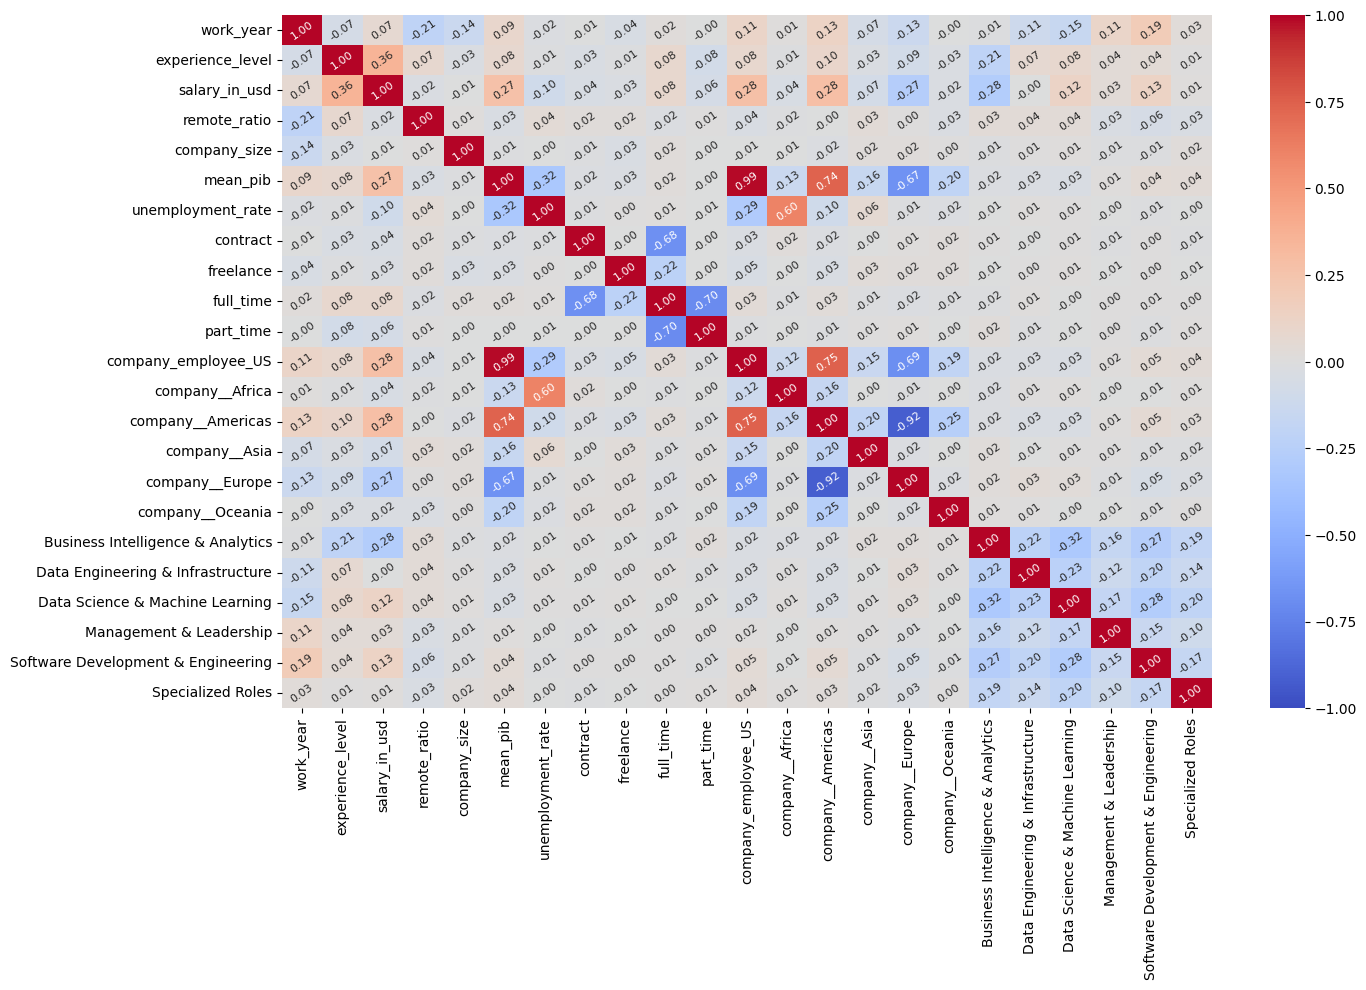

In [112]:
plt.figure(figsize=(15,9))
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, annot_kws={'size': 8, 'rotation': 35}, fmt='.2f' , cmap="coolwarm");

# DF FINAL

In [113]:
#Guardamos la tabla de salarios que tenemos con el análisis hecho hasta ahora
salaries_df.to_csv("data/processed/salaries_final_v2.csv", index=False)